# HUBWAY DATASET

#### This is the subset of Hubway dataset. This database contains the records of all the trips that took place in the month of January 2015. The dataset contains following attributes:
* tripduration - trip duration in seconds
* starttime - time and date at which trip started 
* stoptime - time and date at which trip stopped 
* start_station_id - unique station id from where the trip started
* start_station_name - station name from where the trip started
* start_station_latitude - latitude of start station
* start_station_longitude - longitude of start station
* end_station_id - unique station id where the trip ended
* end_station_name - station name where the trip ended
* end_station_latitude - latitude of end station
* end_station_longitude - longitude of end station
* bikeid - unique bike id of each hubway bike
* usertype - types of hubway users (Subscriber or Customer)
* birth_year - birth year of user
* gender - sex of user (male, female or other)

#### Some of the questions I intend to answer through this dataset are:
* Which are the more popular hubway stations
* Which are the more popular hubway bikes
* Number of users with respect to gender and user type
* Which was the most popular week in the month of January 2015
* Forecast the future user types with respect to trip duration and location of start station and end station

## 1. Data Extraction

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
from patsy import dmatrices
from sklearn import linear_model
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score
import time
import datetime

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#LOADING THE DATASET

hubway = pd.read_csv("https://raw.githubusercontent.com/abhishekpatel47/Hello-world/master/201501-hubway-tripdata.csv")
hubway.head(5)

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,542,1/1/15 0:21,1/1/15 0:30,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,277,Subscriber,1984,1
1,438,1/1/15 0:27,1/1/15 0:34,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,648,Subscriber,1985,1
2,254,1/1/15 0:31,1/1/15 0:35,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,555,Subscriber,1974,1
3,432,1/1/15 0:53,1/1/15 1:00,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1307,Subscriber,1987,1
4,735,1/1/15 1:07,1/1/15 1:19,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,177,Customer,1986,2


## 2. Data Cleaning

In [4]:
#CHECKING IF THERE ARE ANY NULL VALUES

hubway.dropna()
print(hubway.isnull().sum())

tripduration               0
starttime                  0
stoptime                   0
start_station_id           0
start_station_name         0
start_station_latitude     0
start_station_longitude    0
end_station_id             0
end_station_name           0
end_station_latitude       0
end_station_longitude      0
bikeid                     0
usertype                   0
birth_year                 0
gender                     0
dtype: int64


In [5]:
#CHECKING ALL THE COLUMNS AND THEIR DATA TYPE

hubway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7840 entries, 0 to 7839
Data columns (total 15 columns):
tripduration               7840 non-null int64
starttime                  7840 non-null object
stoptime                   7840 non-null object
start_station_id           7840 non-null int64
start_station_name         7840 non-null object
start_station_latitude     7840 non-null float64
start_station_longitude    7840 non-null float64
end_station_id             7840 non-null int64
end_station_name           7840 non-null object
end_station_latitude       7840 non-null float64
end_station_longitude      7840 non-null float64
bikeid                     7840 non-null int64
usertype                   7840 non-null object
birth_year                 7840 non-null object
gender                     7840 non-null int64
dtypes: float64(4), int64(5), object(6)
memory usage: 918.8+ KB


In [6]:
# CONVERTING 'starttime' and 'stoptime' to datetime DATATYPE

hubway['starttime'] = pd.to_datetime(hubway['starttime'])
hubway['stoptime'] = pd.to_datetime(hubway['stoptime'])
hubway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7840 entries, 0 to 7839
Data columns (total 15 columns):
tripduration               7840 non-null int64
starttime                  7840 non-null datetime64[ns]
stoptime                   7840 non-null datetime64[ns]
start_station_id           7840 non-null int64
start_station_name         7840 non-null object
start_station_latitude     7840 non-null float64
start_station_longitude    7840 non-null float64
end_station_id             7840 non-null int64
end_station_name           7840 non-null object
end_station_latitude       7840 non-null float64
end_station_longitude      7840 non-null float64
bikeid                     7840 non-null int64
usertype                   7840 non-null object
birth_year                 7840 non-null object
gender                     7840 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(5), object(4)
memory usage: 918.8+ KB


In [7]:
#EXTRACTING START DATE FROM DATE TIME TYPE COLUMN 'starttime' AND CALLING IT 'date_minus_time' TO FURTHER CALCULATE
#BUSSIEST WEEK IN THE MONTH OF JANUARY 2015

import time
import datetime
hubway['date_minus_time'] = hubway['starttime'].apply(lambda hubway : datetime.datetime(year = hubway.year, month = hubway.month, day = hubway.day))
hubway.set_index(hubway['date_minus_time'], inplace = True)


In [8]:
#UPDATING CATEGORIAL VARIABLE 'usertype' INTO NUMERIC DATATYPE BY UPDATING 'Subscriber' = 1 and 'Customer' = 0

hubway.loc[hubway['usertype'] == 'Subscriber', 'usertype'] = 1
hubway.loc[hubway['usertype'] == 'Customer', 'usertype'] = 0
hubway.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,date_minus_time
date_minus_time,,,,,,,,,,,,,,,,
2015-01-01,542,2015-01-01 00:21:00,2015-01-01 00:30:00,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,277,1,1984,1,2015-01-01
2015-01-01,438,2015-01-01 00:27:00,2015-01-01 00:34:00,80,MIT Stata Center at Vassar St / Main St,42.361962,-71.092053,95,Cambridge St - at Columbia St / Webster Ave,42.372969,-71.094445,648,1,1985,1,2015-01-01
2015-01-01,254,2015-01-01 00:31:00,2015-01-01 00:35:00,91,One Kendall Square at Hampshire St / Portland St,42.366277,-71.091690,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,555,1,1974,1,2015-01-01
2015-01-01,432,2015-01-01 00:53:00,2015-01-01 01:00:00,115,Porter Square Station,42.387995,-71.119084,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1307,1,1987,1,2015-01-01
2015-01-01,735,2015-01-01 01:07:00,2015-01-01 01:19:00,105,Lower Cambridgeport at Magazine St/Riverside Rd,42.356954,-71.113687,88,Inman Square at Vellucci Plaza / Hampshire St,42.374035,-71.101427,177,0,1986,2,2015-01-01


In [9]:
#TYPES OF USERS OF BIKE
print(hubway.usertype.unique())

[1 0]


## 3. Data Visualization

In [10]:
#MOST POPULAR BIKES WITH THEIR AVG TRIPDURATION. THIS CAN ALLOW US TO KNOW WHICH TYPE OF BIKE MODELS ARE MOST POPULAR 
#AMONG THE USERS, SO WE CAN INCREASE THE NUMBER OF SUCH BIKES. 


h = hubway.groupby('bikeid')['tripduration'].mean().reset_index() #AVG TRIPDURATION FOR EACH BIKE
h = h.sort_values(by = 'tripduration', ascending = False)[0:10] #SORTING THE DATAFRAME TO FIND TOP 10 BIKES
h



,bikeid,tripduration
131,800,8083.193548
250,1081,5554.038462
203,956,4509.756098
107,766,2614.973684
178,894,2593.107143
240,1070,2551.421053
36,654,2496.551724
166,880,2242.405405
304,1279,1755.000000
63,690,1568.057143


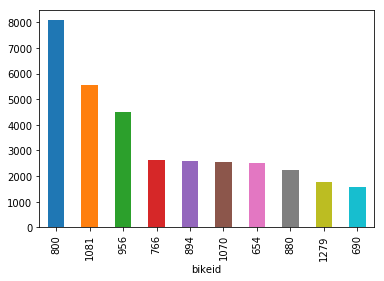

In [11]:
#PLOTTING MOST POPULAR BIKES

h.plot(x = 'bikeid', y = 'tripduration', kind = 'bar', legend = False)

In [12]:
#MOST POPULAR STATIONS. THIS CAN ALLOW US TO KNOW WHERE THE POPULATION OF BIKES SHOULD BE THE MOST.

h1 = hubway.groupby('start_station_name').size().reset_index()
h1 = h1.rename(columns={0 : 'count'})
h1 = h1.sort_values(by = 'count', ascending = False)[0:10]
h1

,start_station_name,count
2,Ames St at Main St,564
27,MIT at Mass Ave / Amherst St,522
8,Central Square at Mass Ave / Essex St,497
29,One Kendall Square at Hampshire St / Portland St,451
20,Inman Square at Vellucci Plaza / Hampshire St,435
26,MIT Stata Center at Vassar St / Main St,399
7,Central Sq Post Office / Cambridge City Hall a...,373
5,Cambridge St - at Columbia St / Webster Ave,354
4,Cambridge Main Library at Broadway / Trowbridg...,318
0,359 Broadway - Broadway at Fayette Street,317


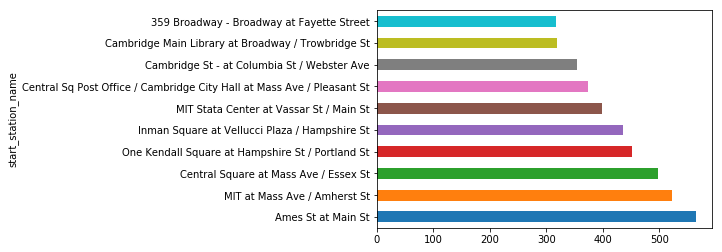

In [13]:
#PLOTTTING MOST POPULAR STATIONS

h1.plot(x = 'start_station_name', y = 'count', kind = 'barh', legend = False)

Text(0.5,1,'SUM OF TRIP DURATION IN EVERY WEEK OF JANUARY')

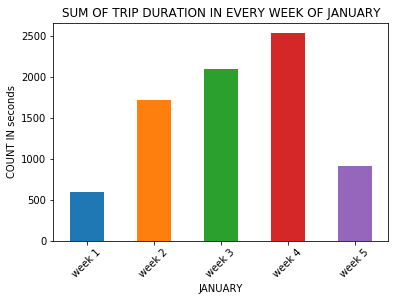

In [14]:
#FINDING OUT MOST POPULAR WEEK OF THE MONTH

hubway['date_minus_time'] = hubway['starttime'].apply(lambda hubway : datetime.datetime(year = hubway.year, month = hubway.month, day = hubway.day))
hubway.set_index(hubway['date_minus_time'], inplace = True)


hubway['tripduration'].groupby(hubway['date_minus_time'].dt.week).count().plot(kind = 'bar')
plt.xlabel('JANUARY')
plt.ylabel('COUNT IN seconds')
plt.xticks(np.arange(5), ('week 1', 'week 2', 'week 3', 'week 4', 'week 5'), rotation = 45)
plt.title('SUM OF TRIP DURATION IN EVERY WEEK OF JANUARY')



Text(0.5,1,'TOTAL NUMBER OF TRIPS EACH DAY')

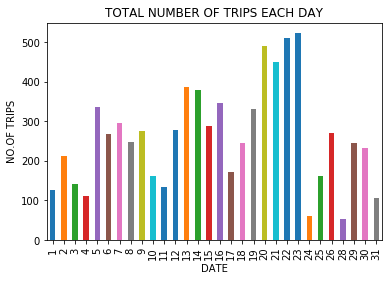

In [15]:
hubway['date_minus_time'].groupby(hubway['date_minus_time'].dt.day).count().plot(kind = 'bar')
plt.xlabel('DATE')
plt.ylabel('NO.OF TRIPS')
plt.title('TOTAL NUMBER OF TRIPS EACH DAY')

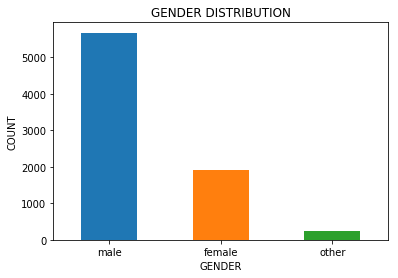

In [16]:
#DISTRIBUTION OF USERS ACCORDING TO GENDER

hubway['gender'].value_counts().plot(kind='bar')
plt.xlabel('GENDER') 
plt.ylabel('COUNT')
plt.title('GENDER DISTRIBUTION')
plt.xticks(np.arange(3), ('male', 'female', 'other'), rotation = 0)
plt.show()

([<matplotlib.axis.XTick at 0x1c181a8ef0>,
 <a list of 2 Text xticklabel objects>)

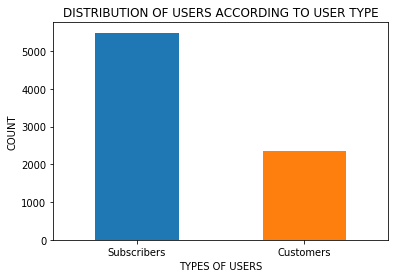

In [17]:
#DISTRIBUTION OF USERS ACCORDING TO USER TYPE

hubway['usertype'].value_counts().plot(kind = 'bar')
plt.xlabel('TYPES OF USERS')
plt.ylabel('COUNT')
plt.title('DISTRIBUTION OF USERS ACCORDING TO USER TYPE')
plt.xticks(np.arange(2), ('Subscribers', 'Customers'), rotation = 0)

## 4. Predictive Analysis

In [18]:
hubway['tripduration'].describe(include='all')

count      7840.000000
mean        647.878444
std        3998.551965
min          62.000000
25%         287.000000
50%         406.000000
75%         602.000000
max      232319.000000
Name: tripduration, dtype: float64

* Minimum trip duration is 62sec (approx 1 minute) and maximum tripduration is 232319sec (approx 60 hours)
* On an average each trip is of 647.9sec (approx 10 minutes)

In [19]:
#DESCRIPTIVE STATISTICS REGARDING HOW WOULD USER TYPE VARY ACCORDING TO THE TRIPDURATION

model1 = smf.OLS.from_formula('usertype ~ tripduration', data = hubway)
results = model1.fit()
print(results.params)
results.summary()

Intercept       6.991499e-01
tripduration    5.245826e-07
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               usertype   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1640
Date:                Sun, 20 May 2018   Prob (F-statistic):              0.685
Time:                        17:10:32   Log-Likelihood:                -5010.5
No. Observations:                7840   AIC:                         1.002e+04
Df Residuals:                    7838   BIC:                         1.004e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.6991      0.005    133.269      0.000       0.689       0.709
tripduration  5.246e-07    1.3e-06      0.405      0.685   -2.01e-06    3.06e-06
==============================================================================
Omnibus:                    11301.673   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1493.921
Skew:                          -0.870   Prob(JB):                         0.00
Kurtosis:                       1.757   Cond. No.                     4.10e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


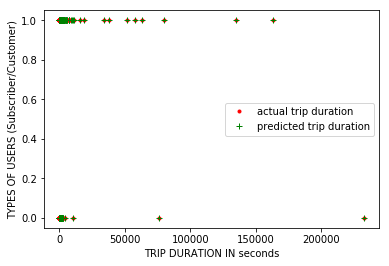

In [20]:
#FORECASTING HOW TYPES OF USERS VARY ACCORDING TO TRIPDURATION AND LOCATION OF HUBWAY BIKE STATIONS WHERE 'Subscriber' = 1
# AND 'Customer' = 0

y, X = dmatrices('usertype ~ tripduration + start_station_latitude + start_station_longitude + end_station_latitude + end_station_longitude', data = hubway)
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X,y)

plt.plot(X[:,1], y, 'r.')
plt.plot(X[:,1], model.predict(X), 'g+')
plt.xlabel('TRIP DURATION IN seconds')
plt.ylabel('TYPES OF USERS (Subscriber/Customer)')
plt.legend(['actual trip duration', 'predicted trip duration'], loc = 0)

In [21]:
print(sklearn.metrics.classification_report(y, model.predict(X)))

             precision    recall  f1-score   support

        0.0       0.95      0.95      0.95      2356
        1.0       0.98      0.98      0.98      5484

avg / total       0.97      0.97      0.97      7840



* With precision score of 0.97 of our random forest classifier model, we can conclude that the user type (subscriber or customer) do not have any visible relation with respect to trip duration and locations of hubway bike statins. Both the type of users are predicted to follow a similar patter, infact according to some outliers in the plot we can see that customers are predicted to exhibit higer trip duration compared to subscriber. Thus I fill the company should take up some unique measures and take some steps towards benefiting their subscribers. This can eventually lead to increase in subscribers and hence winning their trust. 